In [21]:
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import numpy
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.layers import  Dense, Conv2D
from keras.layers import Flatten
from keras.layers.convolutional import MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import tensorflow as tf
from keras.utils import np_utils
%matplotlib inline

In [22]:
print(tf.version.VERSION)
tf.config.list_physical_devices('GPU')

2.7.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
model_type = 'vgg16'

In [24]:
model_home_dir = os.path.join(os.getcwd(), 'CNN_TASK_ODED',"model_type")
print(model_home_dir)
if not os.path.isdir(model_home_dir):
    print('Inside mkdir')
    os.makedirs(model_home_dir)

/home/ec2-user/SageMaker/Research/AWS/CNN_TASK_ODED/model_type


In [25]:
#Defining Variables

#Data set information
DATASET = 'tfds.image_classification.Malaria'
num_classes = 2
input_shape=(32,32,3)
epochs = 200
lrate = 0.01
decay = lrate/epochs
batch_size = 32
seed = 7
np.random.seed(seed)

validate_dir = os.path.join("data","test")
train_dir = os.path.join("data","train")

# Prepare model model saving directory.
save_dir = os.path.join(model_home_dir, 'saved_models')

model_name = DATASET+'_'+'%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print("Model Type: ",model_type)
print("Model File: ",filepath)

Model Type:  vgg16
Model File:  /home/ec2-user/SageMaker/Research/AWS/CNN_TASK_ODED/model_type/saved_models/tfds.image_classification.Malaria_vgg16_model.{epoch:03d}.h5


In [26]:
def preprocess(img, label):
    return tf.image.resize(img, [HEIGHT, WIDTH]) / 255, label

HEIGHT = 32
WIDTH = 32
split = ['train[:85%]', 'train[85%:]']


trainDataset, testDataset = tfds.load('Malaria',
                         split = split,
                         batch_size=1, 
                         as_supervised=True)



trainDataset = trainDataset.map(preprocess)
testDataset = testDataset.map(preprocess)

train = list(tfds.as_numpy(trainDataset))
test = list(tfds.as_numpy(testDataset))

X_train = [e[0][0].astype('float32') for e in train]
X_test = [e[0][0].astype('float32') for e in test]

X_train = numpy.stack(X_train)
X_test = numpy.stack(X_test)

y_train = [e[1][0] for e in train]
y_test = [e[1][0] for e in test]

y_train = numpy.stack(y_train).reshape((-1,1)) 
y_test = numpy.stack(y_test).reshape((-1,1)) 

print(y_train.shape, y_test.shape)
print(X_train.shape, X_test.shape)

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

(23424, 1) (4134, 1)
(23424, 32, 32, 3) (4134, 32, 32, 3)


------------------concatenate train-------------------


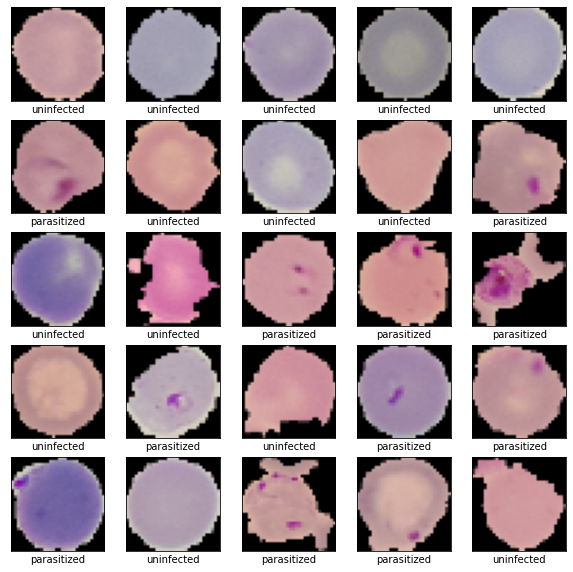

------------------concatenate test-------------------


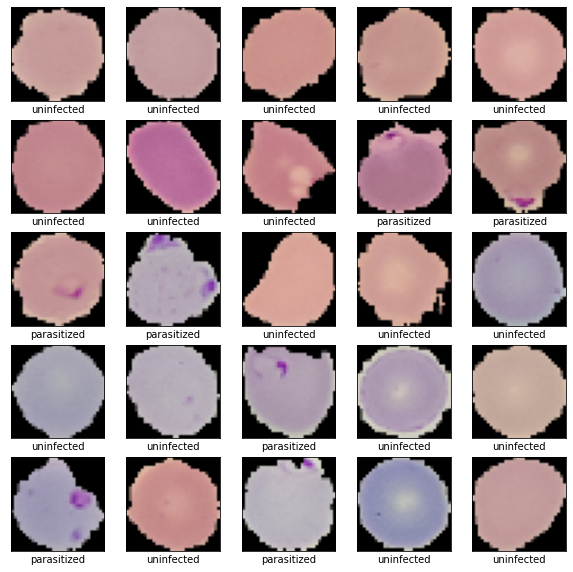

In [27]:
class_names = ['parasitized', 'uninfected']

print("------------------concatenate train-------------------")
plt.figure(figsize=(10,10))
for i in range(25):
    j = random.randint(0,19773)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[j])
    plt.xlabel(class_names[y_train[j][0]])
plt.show()

print("------------------concatenate test-------------------")
plt.figure(figsize=(10,10))
for i in range(25):
    j = random.randint(0,3489) 
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[j])
    plt.xlabel(class_names[y_test[j][0]])
plt.show()

In [28]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


X_train_mean = np.mean(X_train)
X_train -= X_train_mean
X_test_mean = np.mean(X_test)
X_test -= X_test_mean

y_train = np_utils.to_categorical(y_train,)
y_test = np_utils.to_categorical(y_test,)
y_train = np.delete(y_train,1,1)
y_test = np.delete(y_test,1,1)
print(y_train.shape, y_test.shape)



(23424, 1) (4134, 1)


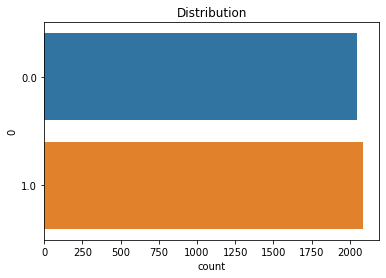

test - parasitized: 2048
test - uninfected: 2086
-------------------------------------------
train - parasitized: 11731
train - uninfected: 11693


In [29]:
import seaborn as sns
import pandas as pd


plt.title('Distribution')
sns.countplot(y = 0, data=pd.DataFrame(y_test))
plt.show()

print(f'test - parasitized: {np.count_nonzero(y_test == 0)}')
print(f'test - uninfected: {np.count_nonzero(y_test == 1)}')

print('-------------------------------------------')

print(f'train - parasitized: {np.count_nonzero(y_train == 0)}')
print(f'train - uninfected: {np.count_nonzero(y_train == 1)}')

In [30]:
from tensorflow.keras.layers import Dropout
def vgg16(input_shape=(32,32,3), num_classes=2):
  model = Sequential()
  model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))


  model.add(Dropout(0.8))

  model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=1, activation="sigmoid"))

  return model

In [31]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [32]:
# Prepare callbacks for model saving and for learning rate adjustment.

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler,early_stopping]


In [33]:
import keras
model = vgg16(input_shape,num_classes)

# Compile model

# optimizer = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=optimizer,
              loss=keras.losses.BinaryCrossentropy(label_smoothing = 0.3),
              metrics=[keras.metrics.BinaryAccuracy()])

print("Model Summary of ",model_type)
print(model.summary())



Model Summary of  vgg16
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 16)        9232      
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 16)        2320      
                              

/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
# Score trained model.
history = model.fit(X_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(X_test, y_test),
      shuffle=True,
      callbacks=callbacks)
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
Epoch 1/200
727/732 [============================>.] - ETA: 0s - loss: 0.6114 - binary_accuracy: 0.7378WARNING:tensorflow:Can save best model only with val_acc available, skipping.


732/732 [==============================] - 4s 5ms/step - loss: 0.6105 - binary_accuracy: 0.7392 - val_loss: 0.5241 - val_binary_accuracy: 0.9107 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
730/732 [============================>.] - ETA: 0s - loss: 0.4758 - binary_accuracy: 0.9472WARNING:tensorflow:Can save best model only with val_acc available, skipping.


732/732 [==============================] - 4s 5ms/step - loss: 0.4756 - binary_accuracy: 0.9473 - val_loss: 0.5081 - val_binary_accuracy: 0.9112 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
729/732 [============================>.] - ETA: 0s - loss: 0.4690 - binary_accuracy: 0.9548WARNING:tensorflow:Can save best model only with val_acc available, skipping.


732/732 [==============================] - 4s 5ms/step - loss: 0.4691 - binary_accuracy: 0.9547 - val_loss: 0.5362 - val_binary_accuracy: 0.8665 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
723/732 [============================>.] - ETA: 0s - loss: 0.4673 - binary_accuracy: 0.9553WARNING:tensorflow:Can save best model only with val_acc available, skipping.


732/732 [==============================] - 4s 5ms/step - loss: 0.4675 - binary_accuracy: 0.9551 - val_loss: 0.5314 - val_binary_accuracy: 0.8752 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
727/732 [============================>.] - ETA: 0s - loss: 0.4658 - binary_accuracy: 0.9571WARNING:tensorflow:Can save best model only with val_acc available, skipping.


732/732 [==============================] - 4s 5ms/step - loss: 0.4657 - binary_accuracy: 0.9573 - val_loss: 0.5222 - val_binary_accuracy: 0.8921 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
730/732 [============================>.] - ETA: 0s - loss: 0.4657 - binary_accuracy: 0.9573WARNING:tensorflow:Can save best model only with val_acc available, skipping.


732/732 [==============================] - 4s 5ms/step - loss: 0.4657 - binary_accuracy: 0.9573 - val_loss: 0.5415 - val_binary_accuracy: 0.8595 - lr: 0.0010
Learning rate:  0.001
Epoch 7/200
727/732 [============================>.] - ETA: 0s - loss: 0.4643 - binary_accuracy: 0.9577WARNING:tensorflow:Can save best model only with val_acc available, skipping.


130/130 [==============================] - 0s 2ms/step - loss: 0.5081 - binary_accuracy: 0.9112
Test loss: 0.5080799460411072
Test accuracy: 0.9112240076065063


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy', 'lr'])


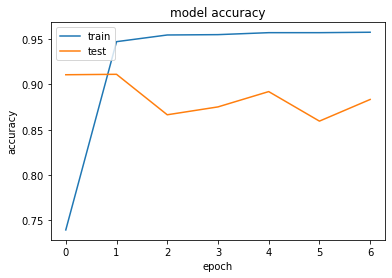

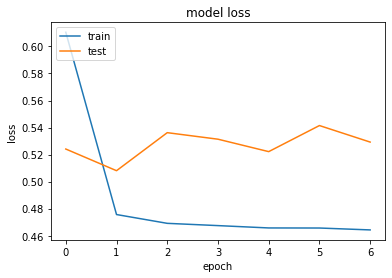

In [35]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

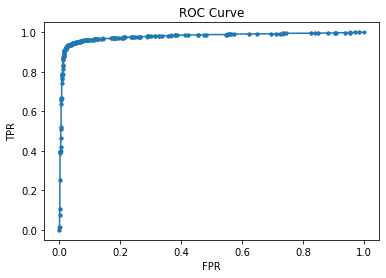

0.9779476410819152


In [36]:
from sklearn.metrics import roc_curve, auc

y_pred = model.predict(X_test).ravel()

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
plt.title('ROC Curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

print(auc_keras)

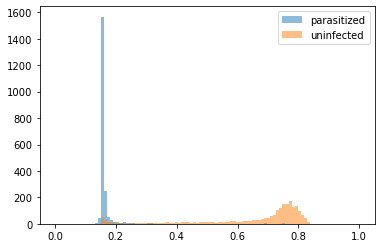

In [37]:
from matplotlib import pyplot
predict_x=model.predict(X_test) 

parasitized_index = np.where(y_test.reshape(-1) == 0.)
parasitized = predict_x[parasitized_index]

uninfected_index = np.where(y_test.reshape(-1) == 1.)
uninfected = predict_x[uninfected_index]



bins = np.linspace(0, 1, 100)

pyplot.hist(parasitized, bins, alpha=0.5, label='parasitized')
pyplot.hist(uninfected, bins, alpha=0.5, label='uninfected')
pyplot.legend(loc='upper right')
pyplot.show()

In [38]:
len(parasitized)

2048

In [39]:
len(uninfected)

2086

In [40]:
# for X,Y in zip(predict_x,y_test):
#     print("Model Score:", X, "actual score:", Y) 